## Set enviroment

In [1]:
# Import modules
import tensorflow as tf
from tensorflow.keras.models import load_model
import nibabel as nib
from niwidgets import NiftiWidget
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, glob

from skimage.measure import marching_cubes_lewiner
import meshplot as mp
from stl import mesh

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

C:\Users\rajah\anaconda3\envs\seg_env\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
# Define constants
HOUNSFIELD_MIN = -1100
HOUNSFIELD_MAX = 3000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

SLICE_X = True
SLICE_Y = True
SLICE_Z = True

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

In [3]:
# Preprocessing utilities

def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN)/HOUNSFIELD_RANGE

def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

In [4]:
# Define paths and load data
DATA_ROOT = 'E:/skia_projects/ct_segmentation_3d/data_slices'
TEST_ROOT = os.path.join(DATA_ROOT, 'test')

targetDir = os.path.join(TEST_ROOT, 'volumes')
resultsDir = os.path.join(DATA_ROOT, 'results')

#imgTargetNii = nib.load(targetImagePath)
#imgTarget = normalizeImageIntensityRange(imgTargetNii.get_fdata())

In [5]:
# Laod model
model = load_model('lung_segmentation_128_128.h5')

## Single slice prediciton

In [6]:
slice_idx = 50

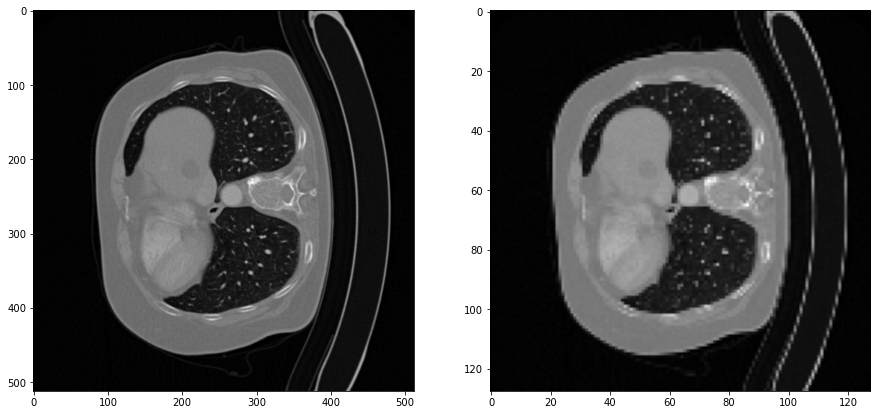

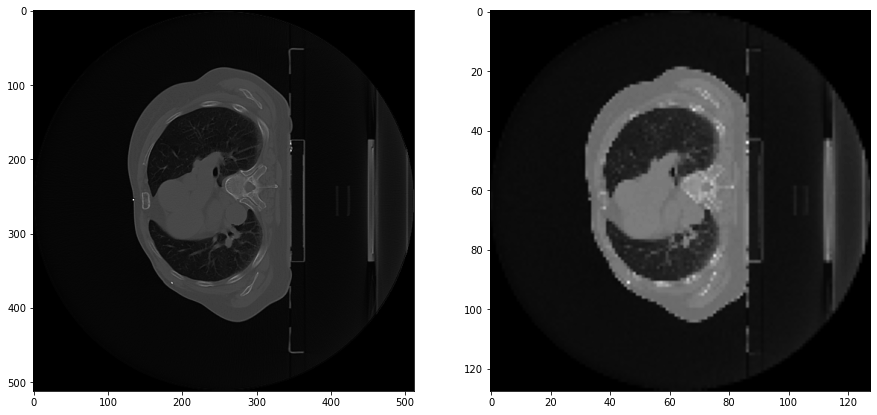

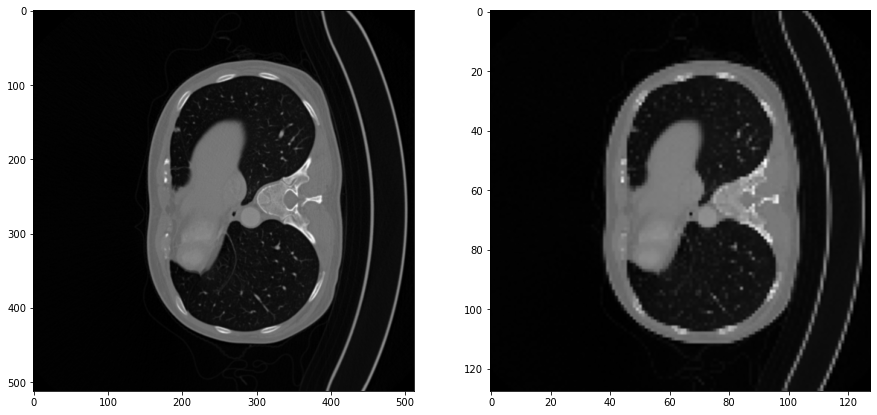

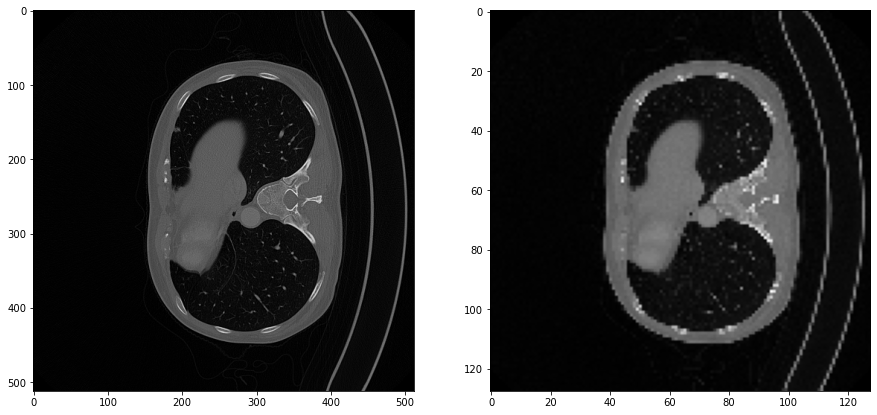

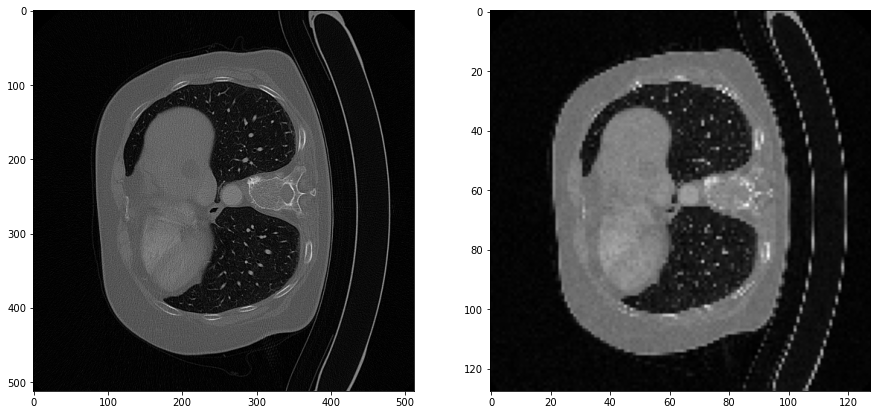

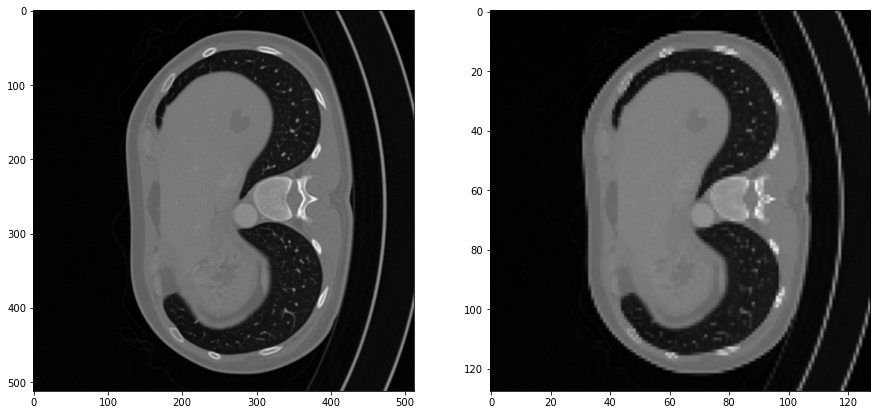

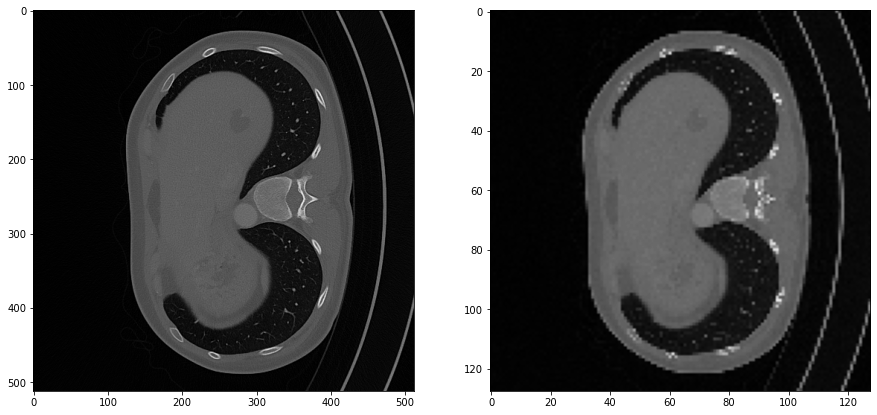

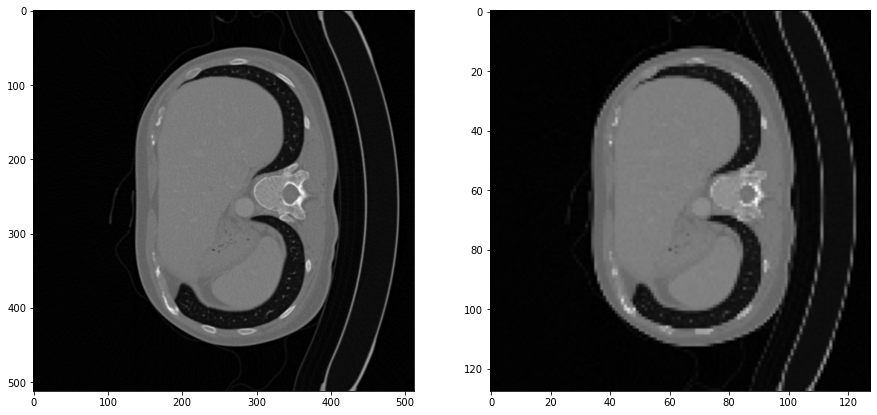

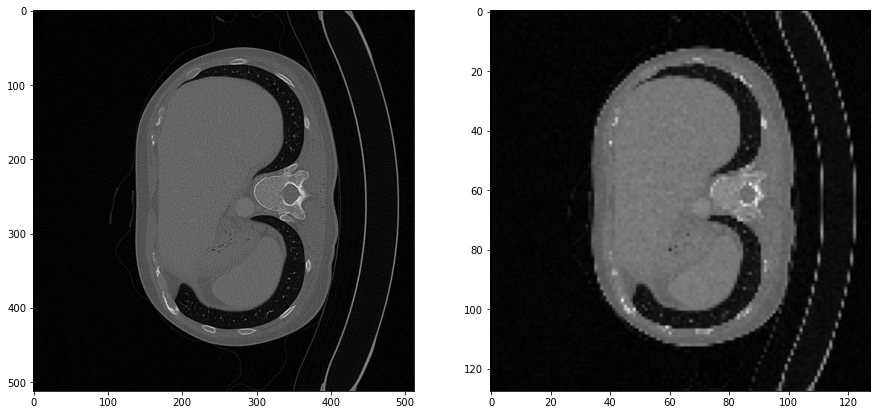

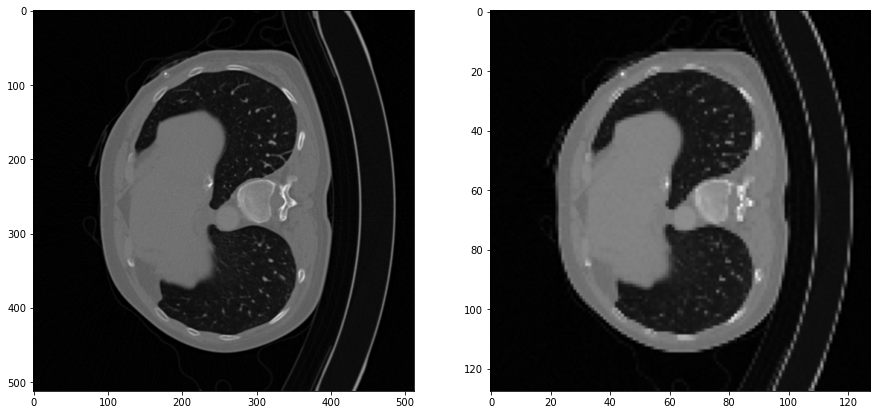

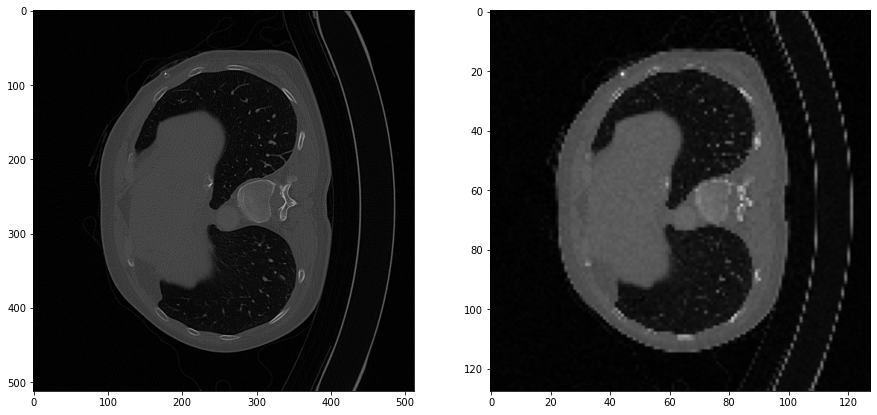

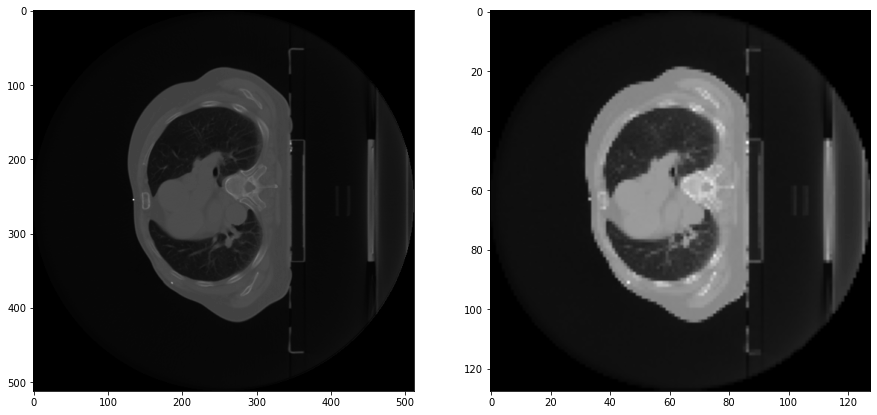

In [7]:
# Show input image slice
for img in glob.glob(targetDir + '/*.nii'):
    imgTargetNii = nib.load(img)
    imgTarget = normalizeImageIntensityRange(imgTargetNii.get_fdata())

    plt.figure(figsize=(15,15))
    imgSlice = imgTarget[:,:,slice_idx]
    img_dimx, img_dimy = imgSlice.shape
    imgSliceScaled = scaleImg(imgSlice, IMAGE_HEIGHT, IMAGE_WIDTH)

    plt.subplot(1,2,1)
    plt.imshow(imgSlice, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(imgSliceScaled, cmap='gray')
    plt.show()
    imgSlice.shape, imgSliceScaled.shape

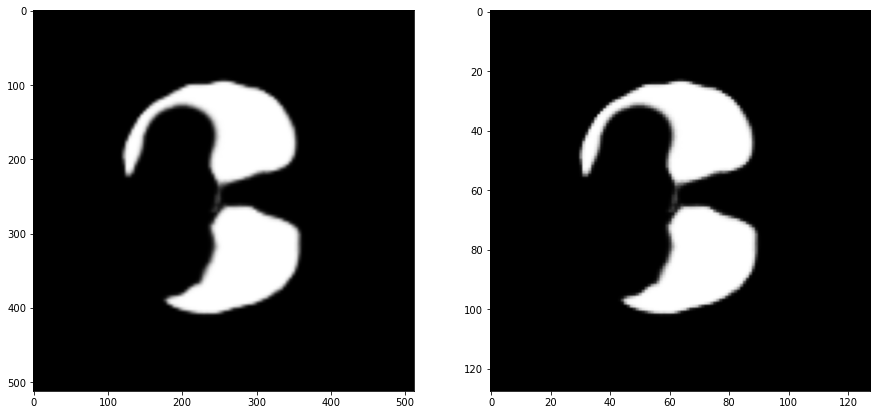

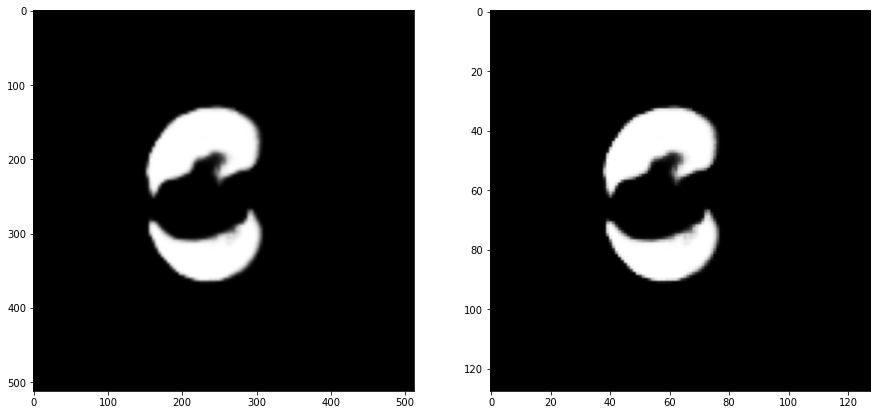

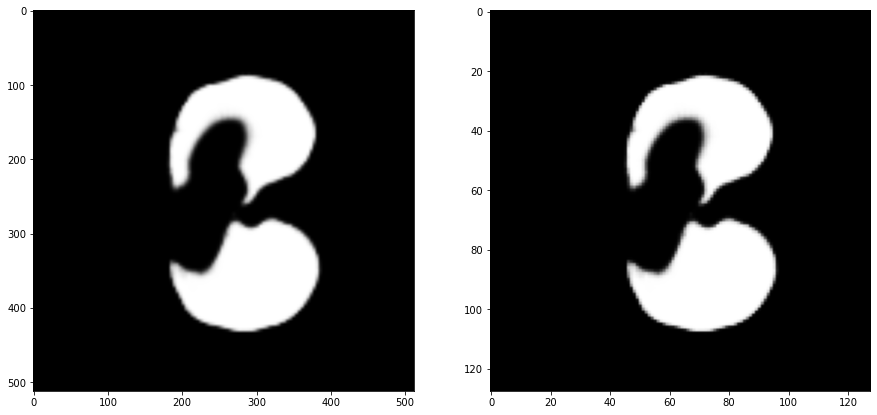

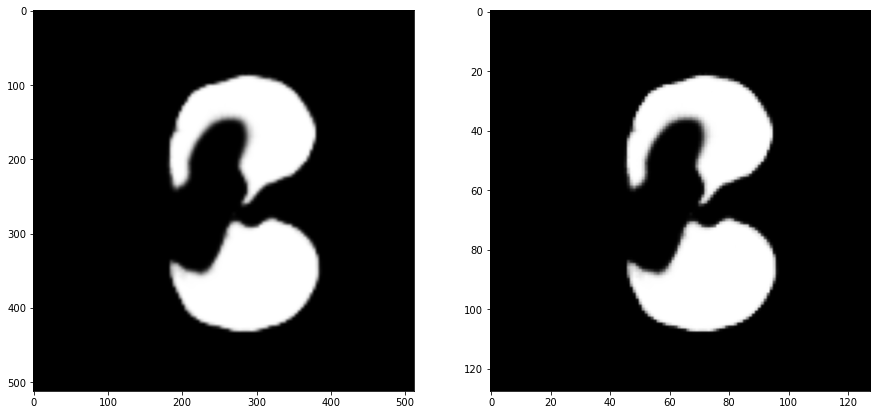

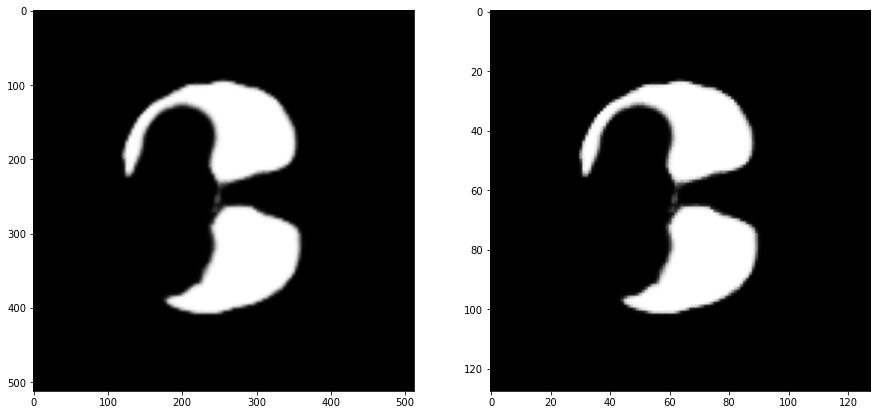

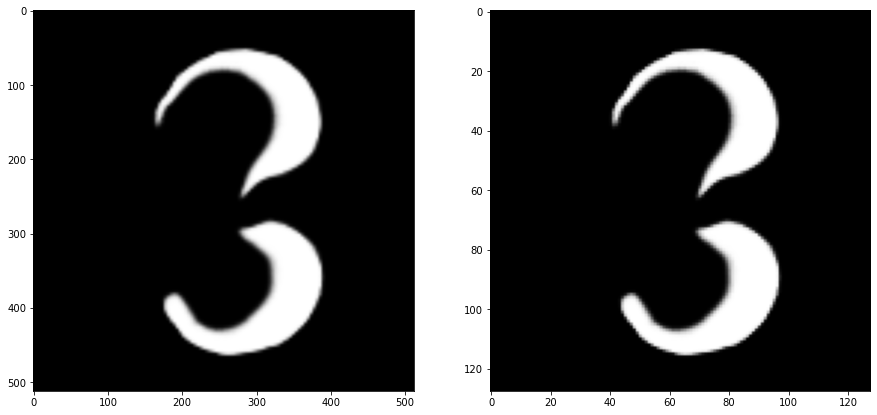

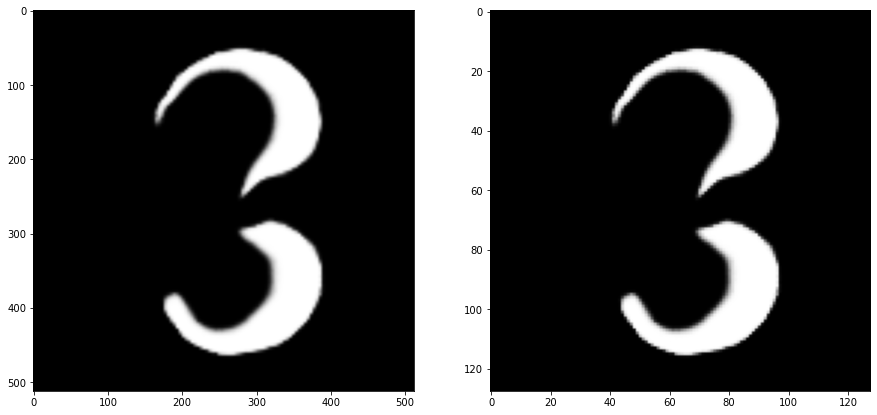

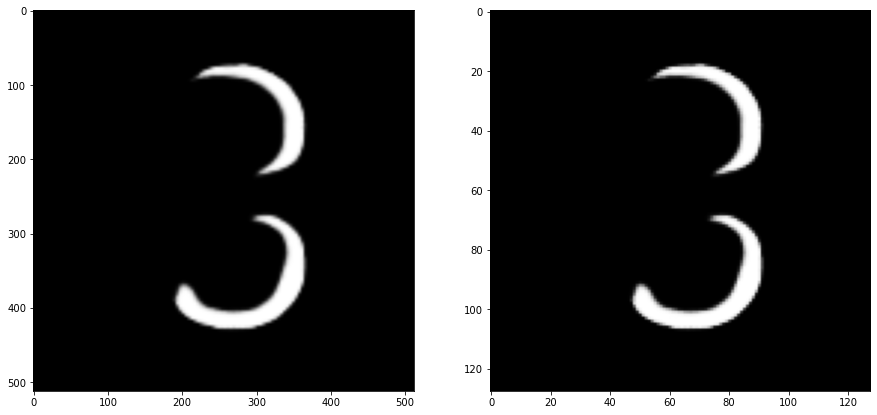

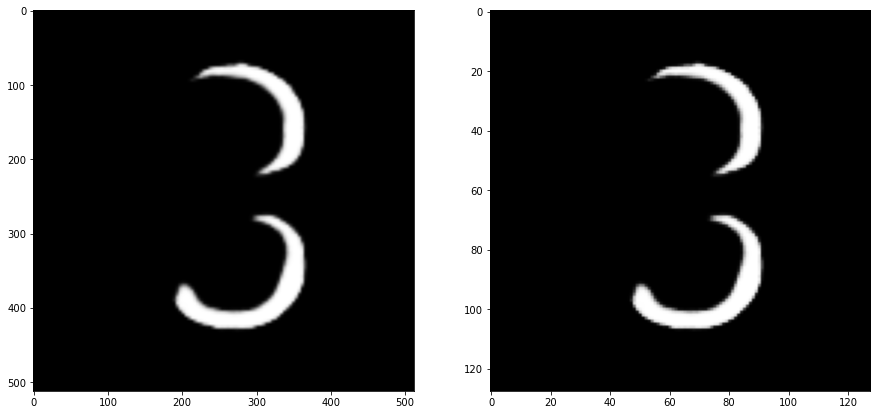

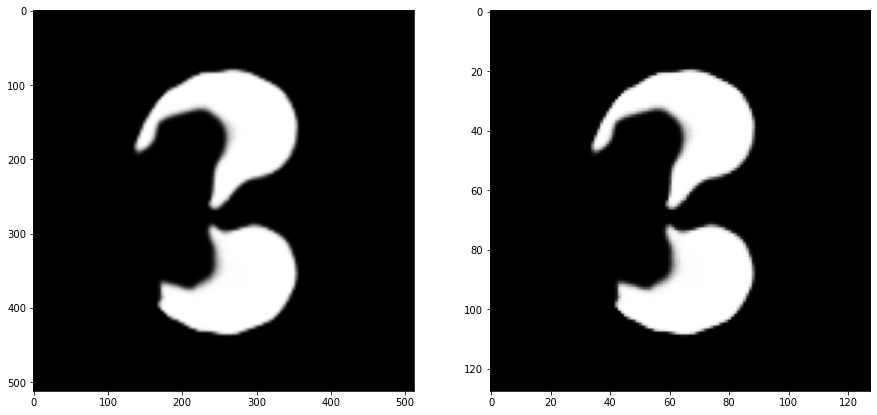

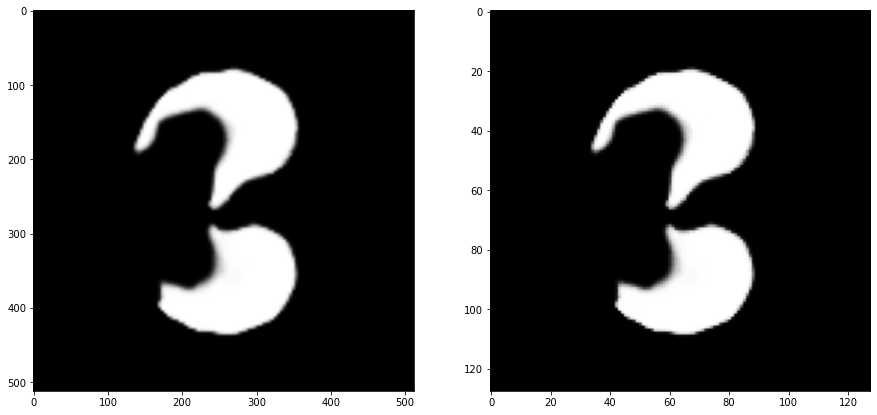

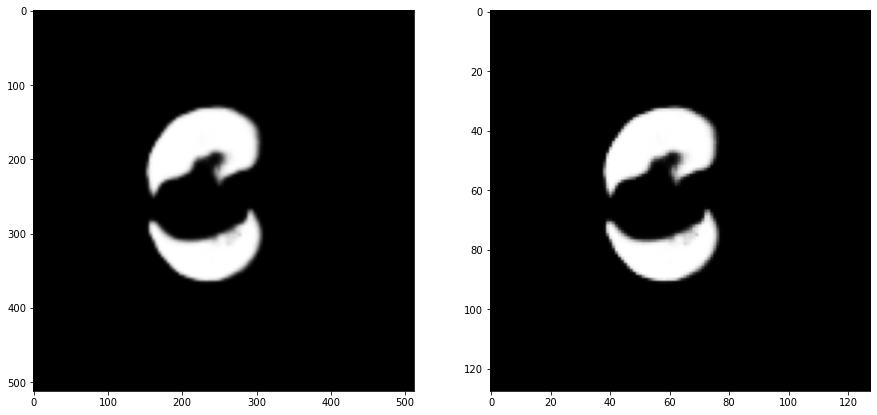

In [8]:
# Predict with UNet model
for img in glob.glob(targetDir + '/*.nii'):
    imgTargetNii = nib.load(img)
    imgTarget = normalizeImageIntensityRange(imgTargetNii.get_fdata())
    
    plt.figure(figsize=(15,15))
    imgSlice = imgTarget[:,:,slice_idx]
    img_dimx, img_dimy = imgSlice.shape
    imgSliceScaled = scaleImg(imgSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
    
    imageInput = imgSliceScaled[np.newaxis,:,:,np.newaxis] # We add two extra axis here i.e. first for number of channels, last for batch size
    maskPredict = model.predict(imageInput)[0,:,:,0] # To get our 2D output
    maskPredictScaled = scaleImg(maskPredict, img_dimx, img_dimy) # Resize to original 512x512

    plt.subplot(1,2,2)
    plt.imshow(maskPredict, cmap='gray')
    plt.subplot(1,2,1)
    plt.imshow(maskPredictScaled, cmap='gray')
    plt.show()
    maskPredictScaled.shape, maskPredict.shape

## Predicting a full volume

In [9]:
# define prediciton function
def predict_volume(volume, toBin=True):
    (xMax, yMax, zMax) = volume.shape
    
    # Create placeholders
    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))
    
    cnt = 0.0 # counts num of directions for slicing
    if SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = scaleImg(volume[i,:,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(volume[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(volume[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)
            
    outImg = (outImgX + outImgY + outImgZ)/cnt # Average prediction
       
    # Convert probability to binary output
    if(toBin):
        outImg[outImg>0.5] = 1.0
        outImg[outImg<=0.5] = 0.0
    return outImg

In [10]:
def dataToMesh(vert, faces):
    mm = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
        for j in range(3):
            mm.vectors[i][j] = vert[f[j],:]
    return mm

In [11]:
# Predict in loop and save as meshes
for idx, img in enumerate(glob.glob(targetDir + '/*.nii')):
    imgTargetNii = nib.load(img)
    imgTarget = normalizeImageIntensityRange(imgTargetNii.get_fdata())
    
    predImg = predict_volume(imgTarget)
    vertices,faces,_,_ = marching_cubes_lewiner(predImg, spacing=(0.7, 0.7, 2.0))
    
    mm = dataToMesh(vertices, faces)
    mm.save(resultsDir + f'/lung-segmented-{idx+1}.stl')